### Data-driven optimization and decision making

### Final project

Juha Reinikainen

In [39]:
import model
import data
import algorithm
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover
import numpy as np

import warnings
warnings.simplefilter("ignore")

# reload changes to self written files
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
df = data.get_data_df()

n_stocks = df.shape[1]
population_size = 100
n_generations = 2000
min_weight = 0.01
max_weight = 0.8
min_stocks = 4
max_stocks = 20

#weight for each stock and whether to 
variable_type_mask = ["real" for _ in range(n_stocks)] + ["bin" for _ in range(n_stocks)]

sampling = MixedVariableSampling(variable_type_mask, {
    "real": get_sampling("real_random"),
    "bin": get_sampling("bin_random")
})

crossover = MixedVariableCrossover(variable_type_mask, {
    "real": get_crossover("real_sbx", prob=1.0, eta=3.0),
    "bin": get_crossover("bin_two_point")
})

mutation = MixedVariableMutation(variable_type_mask, {
    "real": get_mutation("real_pm", eta=3.0, prob=1/50),
    "bin": get_mutation("bin_bitflip", prob=1/50)
})

problem = model.PortfolioSelection(df, min_weight, max_weight, min_stocks, max_stocks, n_stocks)
# problemArima = model.PortfolioSelectionArima(df, w0)

repairMethod = algorithm.OneSumRepair(min_weight, max_weight, n_stocks)

In [41]:
# initial_population = algorithm.createInitialPopulation(population_size, n_stocks)
nsga2 = NSGA2(
    pop_size = population_size, 
    sampling=sampling,
    crossover = crossover,
    mutation = mutation,
    repair = repairMethod
)
res = minimize(problem, nsga2, ("n_gen", n_generations), seed=1, verbose = False)



In [42]:
# initial_population = algorithm.createWeightVectors(population_size, n_stocks)

# nsga2 = NSGA2(pop_size = population_size, sampling=initial_population, repair = repairMethod)
# resArima = minimize(problemArima, nsga2, ("n_gen", n_generations), seed=1, verbose = False)


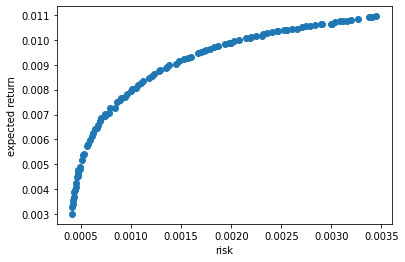

In [43]:
plt.scatter(res.F[:,1], -res.F[:,0], label="simple")
# plt.scatter(resArima.F[:,1], -resArima.F[:,0], label="arima")
plt.xlabel("risk")
plt.ylabel("expected return")
# plt.legend()
plt.show()

In [44]:
Wfinal = res.X[:,:n_stocks]
Yfinal = res.X[:,n_stocks:]
WYfinal = res.X[:,:n_stocks] * res.X[:, n_stocks:] 
#weights add to one?
print((WYfinal).sum(axis=1))

nStocksInEachSolution = Yfinal.sum(axis=1)
#number of stocks between min_stocks and max_stocks?
print(np.logical_and(nStocksInEachSolution >= min_stocks, nStocksInEachSolution <= max_stocks))

[1.0000000000000002 1.0 1.0 1.0 1.0000000000000002 1.0 1.0
 0.9999999999999999 1.0 1.0 1.0000000000000004 1.0 1.0 0.9999999999999999
 0.9999999999999999 1.0 1.0 0.9999999999999998 1.0 1.0 1.0 1.0
 1.0000000000000002 1.0 1.0 1.0 0.9999999999999999 1.0 1.0 1.0 1.0 1.0
 1.0000000000000002 1.0000000000000002 0.9999999999999998 1.0
 0.9999999999999999 1.0 1.0000000000000002 1.0 1.0 1.0 0.9999999999999998
 1.0000000000000002 0.9999999999999999 1.0 1.0 0.9999999999999998 1.0 1.0
 0.9999999999999999 1.0 1.0 1.0 1.0 1.0000000000000002 0.9999999999999999
 1.0000000000000002 1.0000000000000002 1.0000000000000002 1.0
 0.9999999999999999 1.0000000000000002 1.0 0.9999999999999998 1.0
 0.9999999999999999 1.0 1.0 0.9999999999999999 1.0 0.9999999999999998 1.0
 1.0 1.0 1.0 1.0 1.0 0.9999999999999999 1.0 1.0 0.9999999999999999
 0.9999999999999999 0.9999999999999999 1.0 0.9999999999999999
 0.9999999999999999 1.0 0.9999999999999999 1.0 0.9999999999999999 1.0
 0.9999999999999999 1.0000000000000002 1.0 1.000

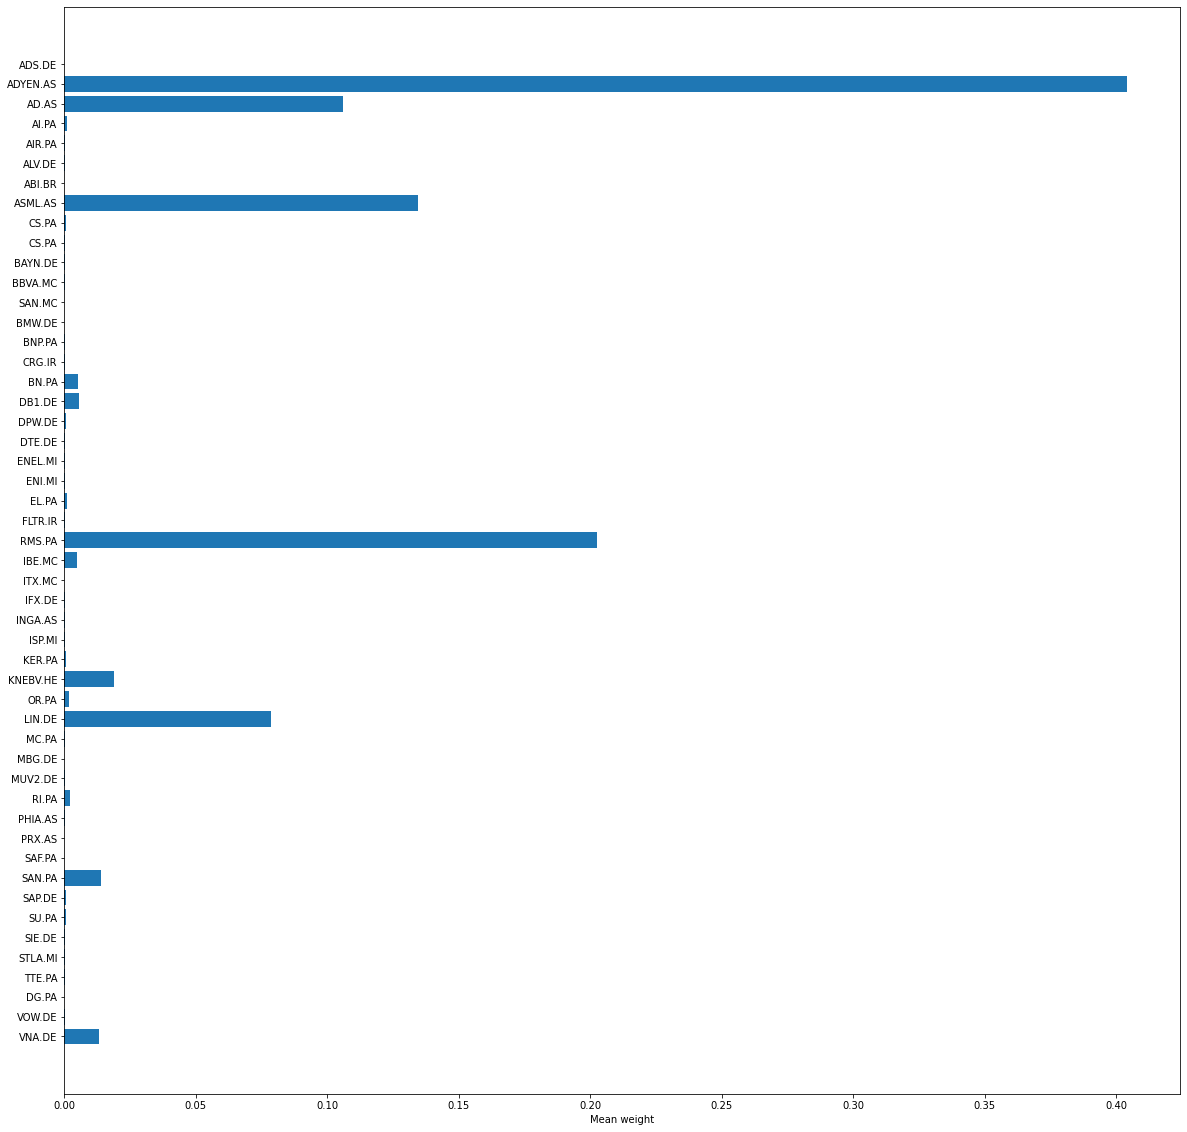

In [45]:
#mean weight for each stock
Wmean = WYfinal.mean(axis=0)
fig, ax = plt.subplots(figsize=(20,20))
ax.barh(range(len(Wmean)), Wmean)
ax.set_yticks(range(len(Wmean)), labels=data.STOCKNAMES)
ax.invert_yaxis()
ax.set_xlabel("Mean weight")

plt.show()